In [ ]:
import numpy as np
import random

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Environment setup
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Reward function: maximize throughput, minimize delay
def reward_function(ed, sap):
    return throughput_matrix[ed, sap] - 2 * delay_matrix[ed, sap]

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        # Get reward for the chosen action
        reward = reward_function(ed, action)

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Optional: Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# Evaluate final coalition assignment
optimal_assignment = np.argmax(q_table, axis=1)

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

# Throughput and delay analysis
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])
print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")


Optimal Coalition Assignments (ED -> SAP): [0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
SAP 1: Devices [0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
SAP 2: Devices [4]
SAP 3: Devices [6]
SAP 4: Devices []
SAP 5: Devices []
Total Throughput: 116.54 Mb/s
Average Delay: 0.48 seconds


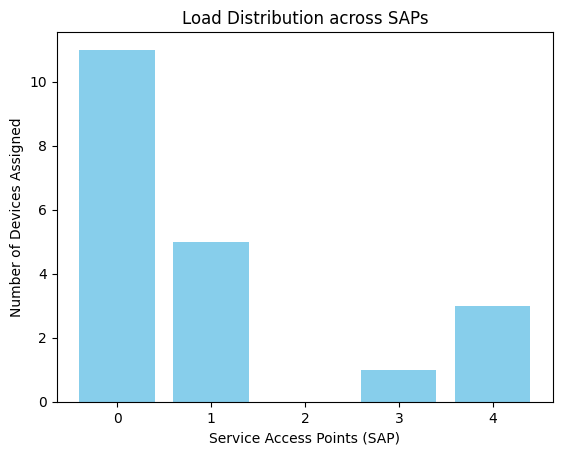

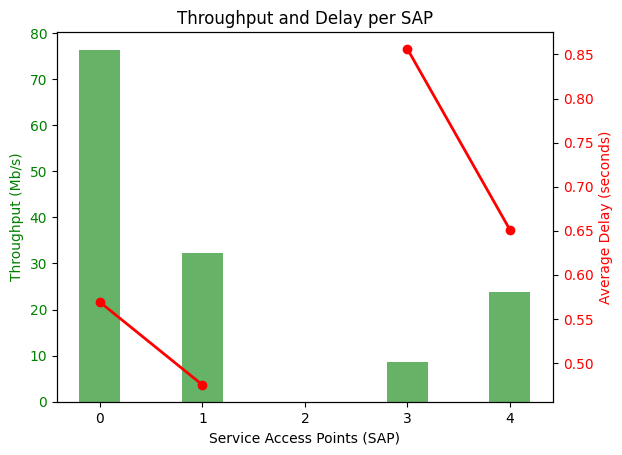

Optimal Coalition Assignments (ED -> SAP): [4 0 0 0 1 3 0 1 1 4 4 0 0 0 0 1 0 0 0 1]
SAP 1: Devices [1, 2, 3, 6, 11, 12, 13, 14, 16, 17, 18]
SAP 2: Devices [4, 7, 8, 15, 19]
SAP 3: Devices []
SAP 4: Devices [5]
SAP 5: Devices [0, 9, 10]
Total Throughput: 141.21 Mb/s
Average Delay: 0.57 seconds


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Adjust this value based on the importance of minimizing delay
beta = 0.25  # Lowered beta for better load balancing

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Min-Max load balancing term with stronger penalty for overloaded SAPs
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Stronger penalty for under-utilization
        return 2 * (3 - load)  # Heavier penalty for SAPs with < 3 devices
    elif load > 12:  # Stronger penalty for overloading
        return 3 * (load - 12)  # Stronger penalty for SAPs with more than 12 devices
    elif load > threshold:
        return load - threshold  # Penalty for overutilization
    else:
        return 0  # No penalty if within the optimal range

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Reward function with load balancing penalty
def reward_function(ed, sap):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Calculate load distribution penalty for the SAP using the new function
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to SAP
    load_penalty = min_max_load_penalty(load)  # Apply Min-Max penalty

    # Total reward considering throughput, delay, and load balancing
    reward = throughput - alpha * delay - beta * load_penalty
    return reward

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        reward = reward_function(ed, action)  # Calculate reward for the selected SAP

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# After training, display the final coalition assignment and performance
optimal_assignment = np.argmax(q_table, axis=1)

# Plotting load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Visualizing throughput and delay
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) for sap in range(num_saps)]

fig, ax1 = plt.subplots()

# Plotting throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Creating a second y-axis for delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

# Throughput and delay analysis
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])
print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")


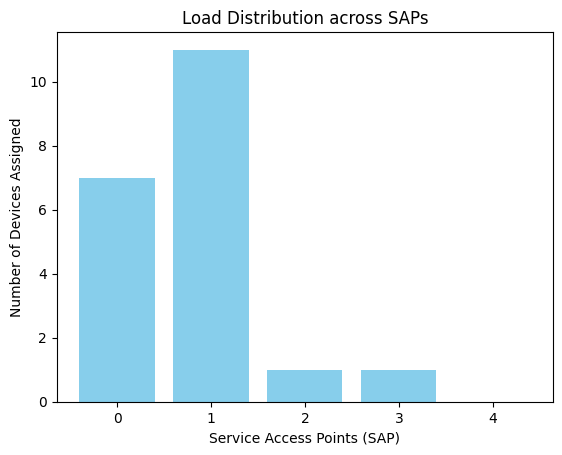

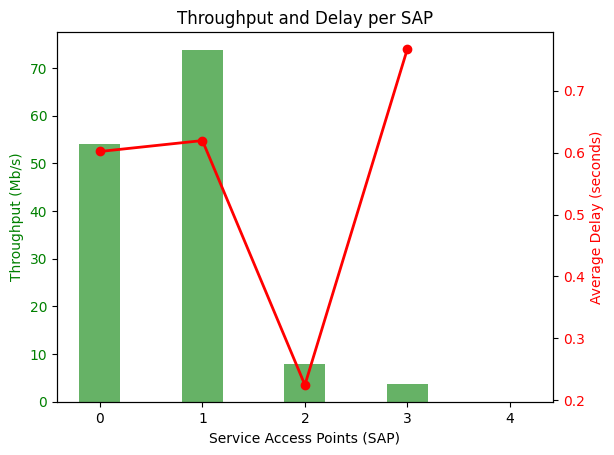

Optimal Coalition Assignments (ED -> SAP): [1 1 1 0 1 1 0 2 0 1 1 1 1 1 1 0 0 0 3 0]
SAP 1: Devices [3, 6, 8, 15, 16, 17, 19]
SAP 2: Devices [0, 1, 2, 4, 5, 9, 10, 11, 12, 13, 14]
SAP 3: Devices [7]
SAP 4: Devices [18]
SAP 5: Devices []
Total Throughput: 139.29 Mb/s
Average Delay: 0.60 seconds


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Adjust this value based on the importance of minimizing delay
beta = 0.25  # Lowered beta for better load balancing

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Min-Max load balancing term with stronger penalty for under-utilized SAPs
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Stronger penalty for under-utilization
        return 2 * (3 - load)  # Heavier penalty for SAPs with < 3 devices
    elif load > 12:  # Stronger penalty for overloading
        return 3 * (load - 12)  # Stronger penalty for SAPs with more than 12 devices
    elif load > threshold:
        return load - threshold  # Penalty for overutilization
    else:
        return 0  # No penalty if within the optimal range

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Reward function with load balancing penalty
def reward_function(ed, sap):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Calculate load distribution penalty for the SAP using the new function
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to SAP
    load_penalty = min_max_load_penalty(load)  # Apply Min-Max penalty

    # Total reward considering throughput, delay, and load balancing
    reward = throughput - alpha * delay - beta * load_penalty
    return reward

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        reward = reward_function(ed, action)  # Calculate reward for the selected SAP

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# After training, display the final coalition assignment and performance
optimal_assignment = np.argmax(q_table, axis=1)

# Plotting load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Visualizing throughput and delay
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) for sap in range(num_saps)]

fig, ax1 = plt.subplots()

# Plotting throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Creating a second y-axis for delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

# Throughput and delay analysis
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])
print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")


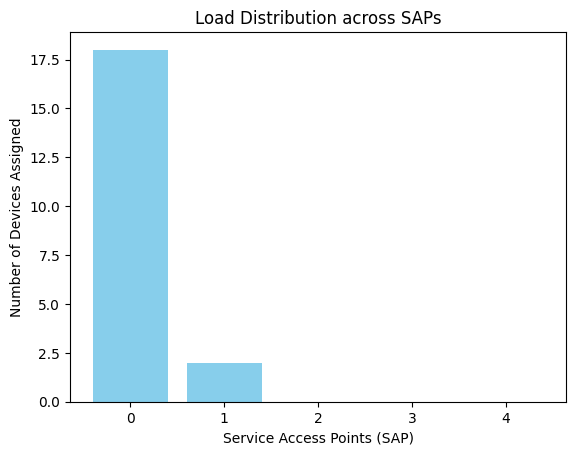

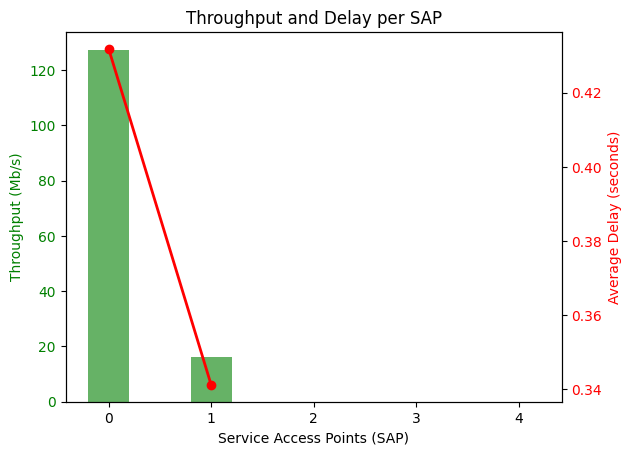

Optimal Coalition Assignments (ED -> SAP): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
SAP 1: Devices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19]
SAP 2: Devices [14, 15]
SAP 3: Devices []
SAP 4: Devices []
SAP 5: Devices []
Total Throughput: 143.52 Mb/s
Average Delay: 0.42 seconds


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Adjust this value based on the importance of minimizing delay
beta = 0.25  # Lowered beta for better load balancing

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Min-Max load balancing term with stronger penalty for overloaded SAPs
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Stronger penalty for under-utilization
        return 2 * (3 - load)  # Heavier penalty for SAPs with < 3 devices
    elif load > 8:  # Stronger penalty for overloading SAP 2
        return 3 * (load - 8)  # Stronger penalty for SAPs with more than 8 devices
    elif load > threshold:
        return load - threshold  # Penalty for overutilization
    else:
        return 0  # No penalty if within the optimal range

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Reward function with load balancing penalty
def reward_function(ed, sap):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Calculate load distribution penalty for the SAP using the new function
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to SAP
    load_penalty = min_max_load_penalty(load)  # Apply Min-Max penalty

    # Total reward considering throughput, delay, and load balancing
    reward = throughput - alpha * delay - beta * load_penalty
    return reward

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        reward = reward_function(ed, action)  # Calculate reward for the selected SAP

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# After training, display the final coalition assignment and performance
optimal_assignment = np.argmax(q_table, axis=1)

# Plotting load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Visualizing throughput and delay
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) for sap in range(num_saps)]

fig, ax1 = plt.subplots()

# Plotting throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Creating a second y-axis for delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

# Throughput and delay analysis
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])
print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")


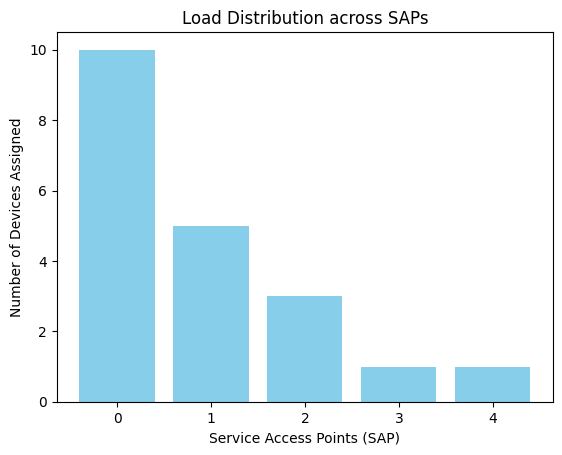

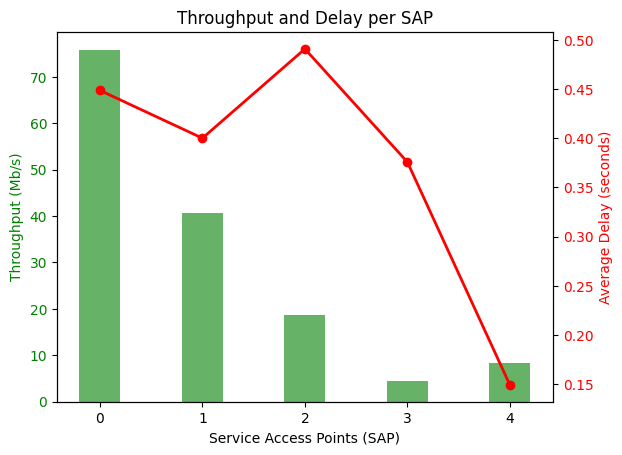

Optimal Coalition Assignments (ED -> SAP): [2 0 1 0 0 0 2 1 0 1 0 1 2 0 0 1 0 3 4 0]
SAP 1: Devices [1, 3, 4, 5, 8, 10, 13, 14, 16, 19]
SAP 2: Devices [2, 7, 9, 11, 15]
SAP 3: Devices [0, 6, 12]
SAP 4: Devices [17]
SAP 5: Devices [18]
Total Throughput: 147.89 Mb/s
Average Delay: 0.42 seconds


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Adjust this value based on the importance of minimizing delay
beta = 0.25  # Lowered beta for better load balancing

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Min-Max load balancing term with stronger penalty for overloaded SAPs
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Stronger penalty for under-utilization
        return 2 * (3 - load)  # Heavier penalty for SAPs with < 3 devices
    elif load > 10:  # Stronger penalty for overloading SAP 1
        return 3 * (load - 10)  # Stronger penalty for SAPs with more than 10 devices
    elif load > threshold:
        return load - threshold  # Penalty for overutilization
    else:
        return 0  # No penalty if within the optimal range

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Reward function with load balancing penalty
def reward_function(ed, sap):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Calculate load distribution penalty for the SAP using the new function
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to SAP
    load_penalty = min_max_load_penalty(load)  # Apply Min-Max penalty

    # Total reward considering throughput, delay, and load balancing
    reward = throughput - alpha * delay - beta * load_penalty
    return reward

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        reward = reward_function(ed, action)  # Calculate reward for the selected SAP

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# After training, display the final coalition assignment and performance
optimal_assignment = np.argmax(q_table, axis=1)

# Plotting load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Visualizing throughput and delay
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) for sap in range(num_saps)]

fig, ax1 = plt.subplots()

# Plotting throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Creating a second y-axis for delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

# Throughput and delay analysis
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])
print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")


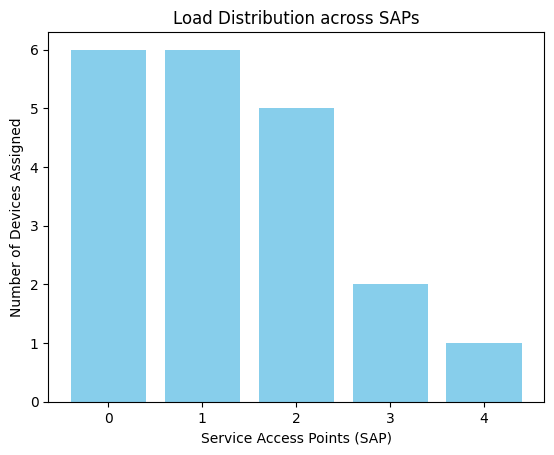

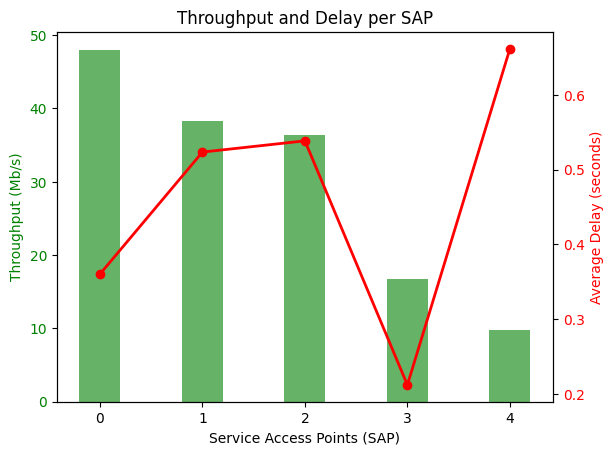

Optimal Coalition Assignments (ED -> SAP): [1 0 1 0 0 1 1 3 3 0 4 0 2 1 2 1 2 0 2 2]
SAP 1: Devices [1, 3, 4, 9, 11, 17]
SAP 2: Devices [0, 2, 5, 6, 13, 15]
SAP 3: Devices [12, 14, 16, 18, 19]
SAP 4: Devices [7, 8]
SAP 5: Devices [10]
Total Throughput: 149.25 Mb/s
Average Delay: 0.45 seconds


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Adjust this value based on the importance of minimizing delay
beta = 0.25  # Lowered beta for better load balancing

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Min-Max load balancing term with stronger penalty for overloading SAP 2
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Stronger penalty for under-utilization
        return 2 * (3 - load)  # Heavier penalty for SAPs with < 3 devices
    elif load > 10:  # Stronger penalty for overloading SAP 2
        return 3 * (load - 10)  # Stronger penalty for SAPs with more than 10 devices
    elif load > threshold:
        return load - threshold  # Penalty for overutilization
    else:
        return 0  # No penalty if within the optimal range

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Reward function with load balancing penalty
def reward_function(ed, sap):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Calculate load distribution penalty for the SAP using the new function
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to SAP
    load_penalty = min_max_load_penalty(load)  # Apply Min-Max penalty

    # Total reward considering throughput, delay, and load balancing
    reward = throughput - alpha * delay - beta * load_penalty
    return reward

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        reward = reward_function(ed, action)  # Calculate reward for the selected SAP

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# After training, display the final coalition assignment and performance
optimal_assignment = np.argmax(q_table, axis=1)

# Plotting load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Visualizing throughput and delay
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) for sap in range(num_saps)]

fig, ax1 = plt.subplots()

# Plotting throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Creating a second y-axis for delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

# Throughput and delay analysis
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])
print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")


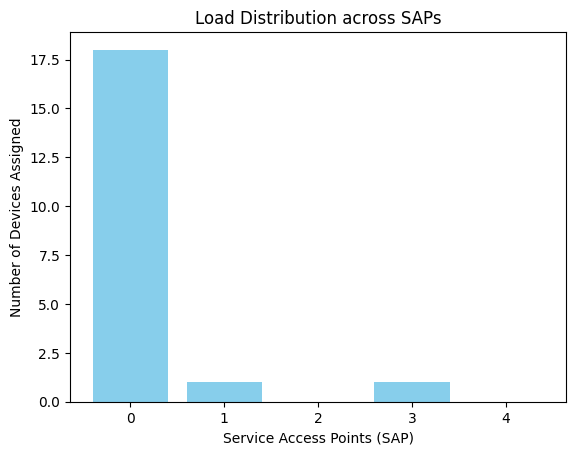

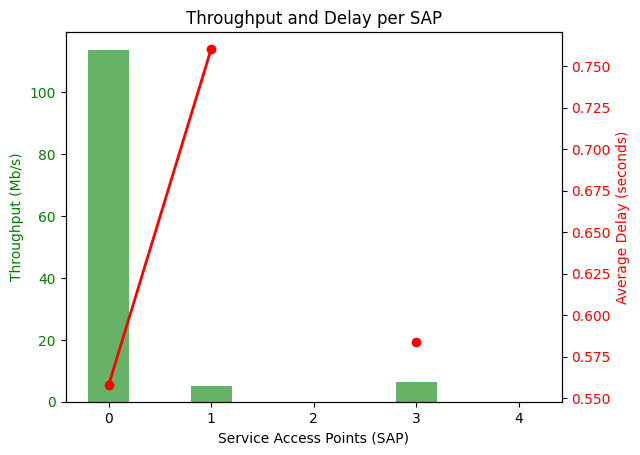

Optimal Coalition Assignments (ED -> SAP): [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 0 0]
SAP 1: Devices [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19]
SAP 2: Devices [17]
SAP 3: Devices []
SAP 4: Devices [7]
SAP 5: Devices []
Total Throughput: 125.25 Mb/s
Average Delay: 0.57 seconds


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Adjust this value based on the importance of minimizing delay
beta = 0.25  # Lowered beta for better load balancing

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Min-Max load balancing term with stronger penalty for under-utilized SAPs
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Stronger penalty for under-utilization
        return 2 * (3 - load)  # Heavier penalty for SAPs with < 3 devices
    elif load > 10:  # Stronger penalty for overloading SAP 1
        return 3 * (load - 10)  # Stronger penalty for SAPs with more than 10 devices
    elif load > threshold:
        return load - threshold  # Penalty for overutilization
    else:
        return 0  # No penalty if within the optimal range

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Reward function with load balancing penalty
def reward_function(ed, sap):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Calculate load distribution penalty for the SAP using the new function
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to SAP
    load_penalty = min_max_load_penalty(load)  # Apply Min-Max penalty

    # Total reward considering throughput, delay, and load balancing
    reward = throughput - alpha * delay - beta * load_penalty
    return reward

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        reward = reward_function(ed, action)  # Calculate reward for the selected SAP

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# After training, display the final coalition assignment and performance
optimal_assignment = np.argmax(q_table, axis=1)

# Plotting load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Visualizing throughput and delay
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) for sap in range(num_saps)]

fig, ax1 = plt.subplots()

# Plotting throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Creating a second y-axis for delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

# Throughput and delay analysis
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])
print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")


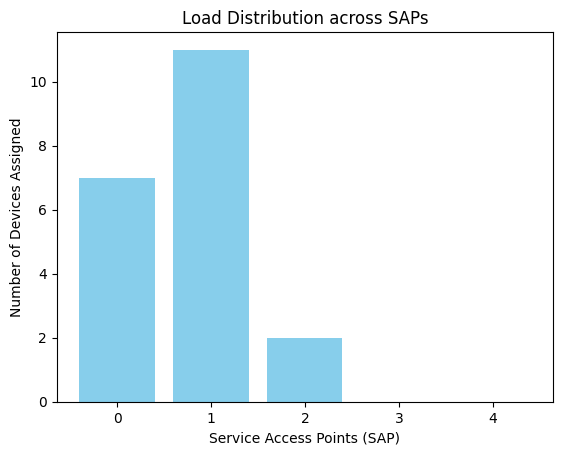

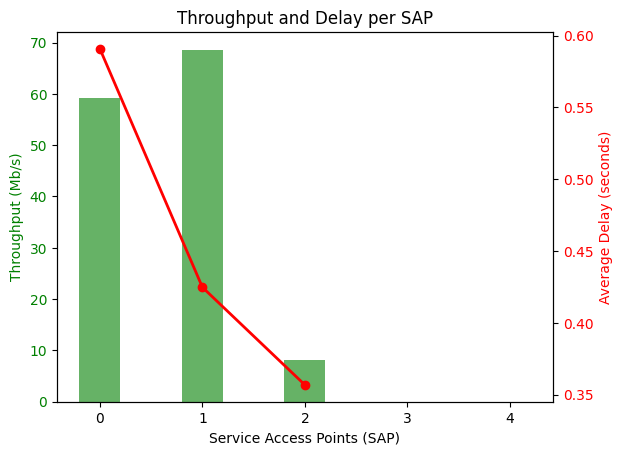

Optimal Coalition Assignments (ED -> SAP): [0 0 1 2 0 0 1 0 0 1 1 0 1 1 1 2 1 1 1 1]
SAP 1: Devices [0, 1, 4, 5, 7, 8, 11]
SAP 2: Devices [2, 6, 9, 10, 12, 13, 14, 16, 17, 18, 19]
SAP 3: Devices [3, 15]
SAP 4: Devices []
SAP 5: Devices []
Total Throughput: 136.03 Mb/s
Average Delay: 0.48 seconds


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Adjust this value based on the importance of minimizing delay
beta = 0.25  # Lowered beta for better load balancing

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Min-Max load balancing term with stronger penalty for overloading SAP 1
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Stronger penalty for under-utilization
        return 2 * (3 - load)  # Heavier penalty for SAPs with < 3 devices
    elif load > 10:  # Stronger penalty for overloading SAP 1
        return 3 * (load - 10)  # Stronger penalty for SAPs with more than 10 devices
    elif load > threshold:
        return load - threshold  # Penalty for overutilization
    else:
        return 0  # No penalty if within the optimal range

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Reward function with load balancing penalty
def reward_function(ed, sap):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Calculate load distribution penalty for the SAP using the new function
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to SAP
    load_penalty = min_max_load_penalty(load)  # Apply Min-Max penalty

    # Total reward considering throughput, delay, and load balancing
    reward = throughput - alpha * delay - beta * load_penalty
    return reward

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        reward = reward_function(ed, action)  # Calculate reward for the selected SAP

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# After training, display the final coalition assignment and performance
optimal_assignment = np.argmax(q_table, axis=1)

# Plotting load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Visualizing throughput and delay
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) for sap in range(num_saps)]

fig, ax1 = plt.subplots()

# Plotting throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Creating a second y-axis for delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

# Throughput and delay analysis
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])
print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")


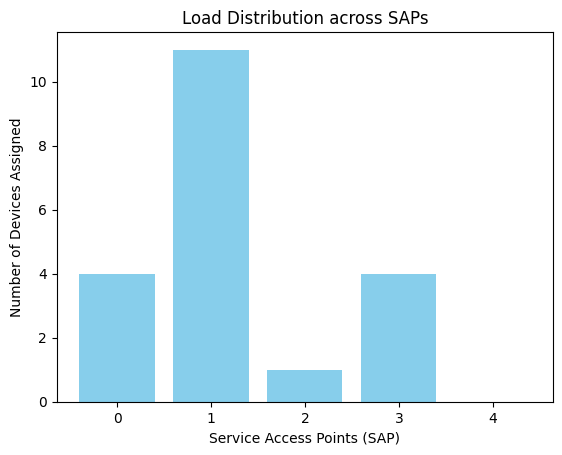

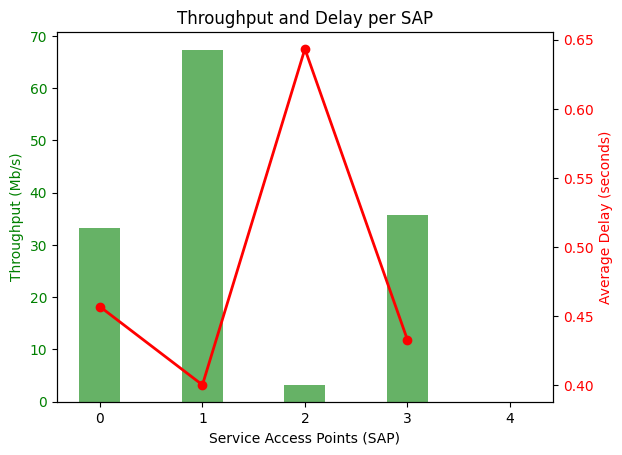

Optimal Coalition Assignments (ED -> SAP): [1 1 0 3 1 1 3 0 2 1 0 1 1 1 0 3 3 1 1 1]
SAP 1: Devices [2, 7, 10, 14]
SAP 2: Devices [0, 1, 4, 5, 9, 11, 12, 13, 17, 18, 19]
SAP 3: Devices [8]
SAP 4: Devices [3, 6, 15, 16]
SAP 5: Devices []
Total Throughput: 139.60 Mb/s
Average Delay: 0.43 seconds


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Adjust this value based on the importance of minimizing delay
beta = 0.25  # Lowered beta for better load balancing

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Min-Max load balancing term with stronger penalty for under-utilized SAPs
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Stronger penalty for under-utilization
        return 2 * (3 - load)  # Heavier penalty for SAPs with < 3 devices
    elif load > 10:  # Stronger penalty for overloading SAP 1 or SAP 2
        return 3 * (load - 10)  # Stronger penalty for SAPs with more than 10 devices
    elif load > threshold:
        return load - threshold  # Penalty for overutilization
    else:
        return 0  # No penalty if within the optimal range

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Reward function with load balancing penalty
def reward_function(ed, sap):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Calculate load distribution penalty for the SAP using the new function
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to SAP
    load_penalty = min_max_load_penalty(load)  # Apply Min-Max penalty

    # Total reward considering throughput, delay, and load balancing
    reward = throughput - alpha * delay - beta * load_penalty
    return reward

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        reward = reward_function(ed, action)  # Calculate reward for the selected SAP

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# After training, display the final coalition assignment and performance
optimal_assignment = np.argmax(q_table, axis=1)

# Plotting load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Visualizing throughput and delay
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) for sap in range(num_saps)]

fig, ax1 = plt.subplots()

# Plotting throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Creating a second y-axis for delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

# Throughput and delay analysis
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])
print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")


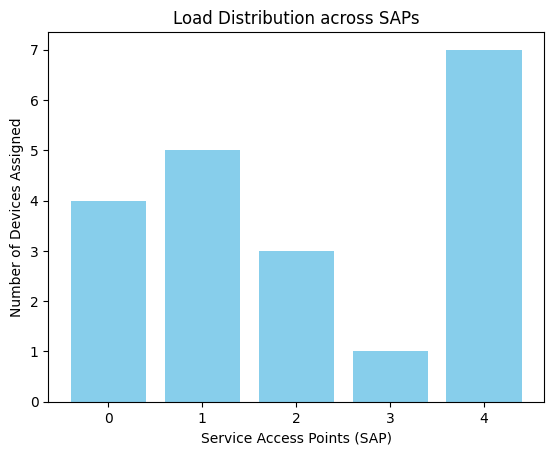

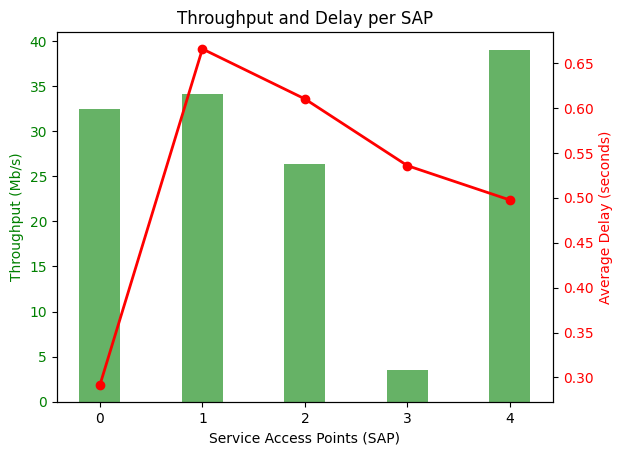

Optimal Coalition Assignments (ED -> SAP): [1 2 2 4 4 0 4 0 1 4 2 0 3 4 4 0 4 1 1 1]
SAP 1: Devices [5, 7, 11, 15]
SAP 2: Devices [0, 8, 17, 18, 19]
SAP 3: Devices [1, 2, 10]
SAP 4: Devices [12]
SAP 5: Devices [3, 4, 6, 9, 13, 14, 16]
Total Throughput: 135.53 Mb/s
Average Delay: 0.52 seconds


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1500  # Increased number of training episodes
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.2  # Increased initial exploration rate
alpha = 0.5  # Weight for delay penalty
beta = 0.25  # Weight for load penalty

# Environment setup (simulated throughput and delay values)
np.random.seed(42)  # For reproducibility
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Penalty function for load balancing with stronger penalties for under/over-utilized SAPs
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Penalty for under-utilization
        return 3 * (3 - load)
    elif load > 7 and load <= 10:  # Moderate penalty for moderate overloading
        return 2 * (load - 7)
    elif load > 10:  # Stronger penalty for heavy overloading
        return 5 * (load - 10)
    else:
        return 0  # No penalty if within the optimal range

# Reward function with incentives for balanced load and penalties for over/under-utilization
def reward_function(ed, sap):
    load = np.sum(optimal_assignment == sap)  # Current load on SAP
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    load_penalty = min_max_load_penalty(load)  # Penalty for load imbalance
    under_utilized_bonus = 10 if sap == 4 else 0  # Reward for assigning to underutilized SAP 5

    # Total reward
    reward = throughput - alpha * delay - beta * load_penalty + under_utilized_bonus
    return reward

# Initialize Q-Table
q_table = np.zeros((num_eds, num_saps))

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        # Calculate reward
        reward = reward_function(ed, action)

        # Update Q-Table using the Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.995)

# Determine the optimal coalition assignments
optimal_assignment = np.argmax(q_table, axis=1)

# Load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

# Throughput and delay per SAP
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) if np.sum(optimal_assignment == sap) > 0 else 0 for sap in range(num_saps)]

# Total throughput and average delay
total_throughput = sum(throughput_per_sap)
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])

# Visualize Load Distribution
plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Visualize Throughput and Delay
fig, ax1 = plt.subplots()
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Print Results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")


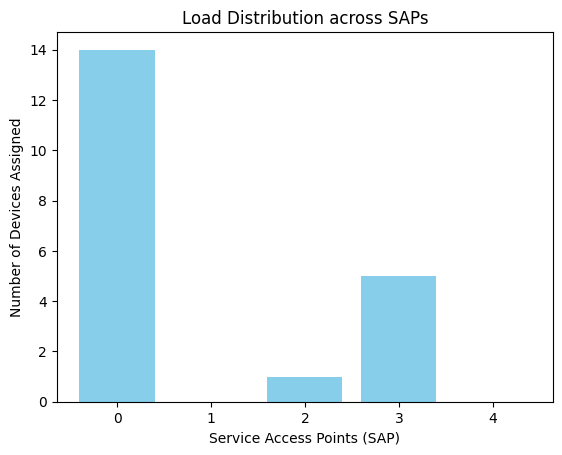

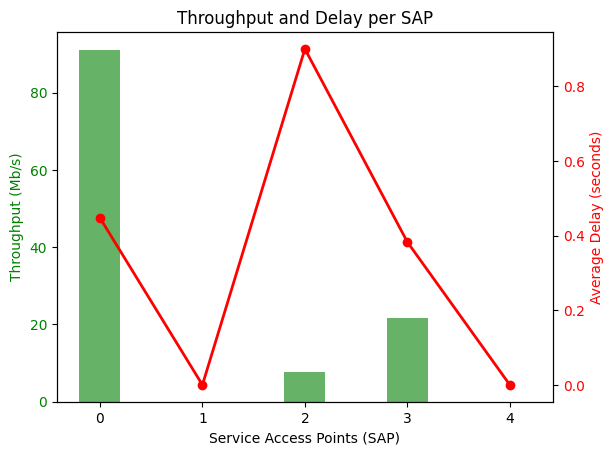

Optimal Coalition Assignments (ED -> SAP): [0 3 3 0 0 0 0 0 3 0 0 0 3 3 0 0 0 0 2 0]
SAP 1: Devices [0, 3, 4, 5, 6, 7, 9, 10, 11, 14, 15, 16, 17, 19]
SAP 2: Devices []
SAP 3: Devices [18]
SAP 4: Devices [1, 2, 8, 12, 13]
SAP 5: Devices []
Total Throughput: 120.23 Mb/s
Average Delay: 0.45 seconds


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 2000  # Increased number of training episodes
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.2  # Increased initial exploration rate
alpha = 0.5  # Weight for delay penalty
beta = 0.25  # Weight for load penalty

# Environment setup (simulated throughput and delay values)
np.random.seed(42)  # For reproducibility
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Penalty function for load balancing
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Penalty for under-utilization
        return 3 * (3 - load)
    elif load > 5 and load <= 7:  # Moderate penalty for moderate overloading
        return 2 * (load - 5)
    elif load > 7:  # Strong penalty for heavy overloading
        return 5 * (load - 7)
    else:
        return 0  # No penalty if within the optimal range

# Reward function with incentives for balanced load and penalties for over/under-utilization
def reward_function(ed, sap):
    load = np.sum(optimal_assignment == sap)  # Current load on SAP
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Apply penalties and rewards
    load_penalty = min_max_load_penalty(load)  # Penalty for load imbalance
    under_utilized_bonus = 15 if sap == 3 else 0  # Encourage utilization of SAP 4

    # Total reward
    reward = throughput - alpha * delay - beta * load_penalty + under_utilized_bonus
    return reward

# Initialize Q-Table
q_table = np.zeros((num_eds, num_saps))

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        # Calculate reward
        reward = reward_function(ed, action)

        # Update Q-Table using the Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.995)

# Determine the optimal coalition assignments
optimal_assignment = np.argmax(q_table, axis=1)

# Load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

# Throughput and delay per SAP
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) if np.sum(optimal_assignment == sap) > 0 else 0 for sap in range(num_saps)]

# Total throughput and average delay
total_throughput = sum(throughput_per_sap)
average_delay = np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds)])

# Visualize Load Distribution
plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Visualize Throughput and Delay
fig, ax1 = plt.subplots()
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Print Results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")



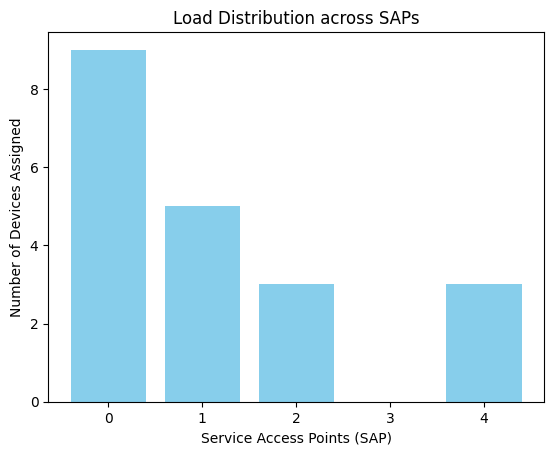

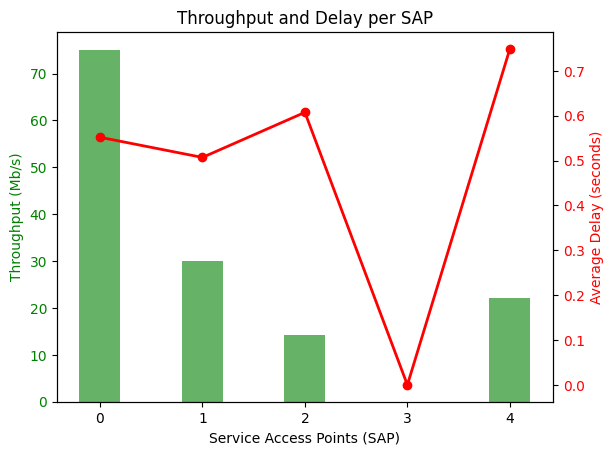

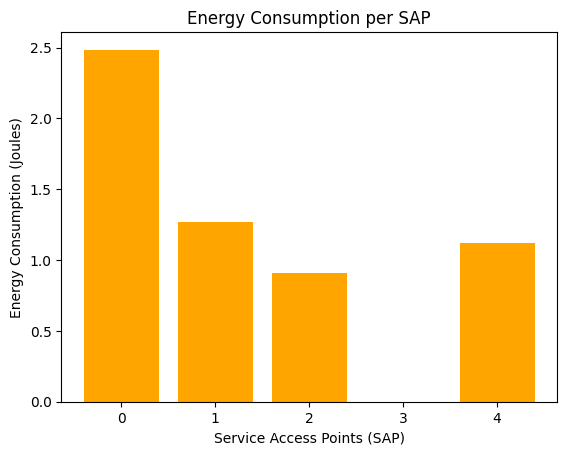

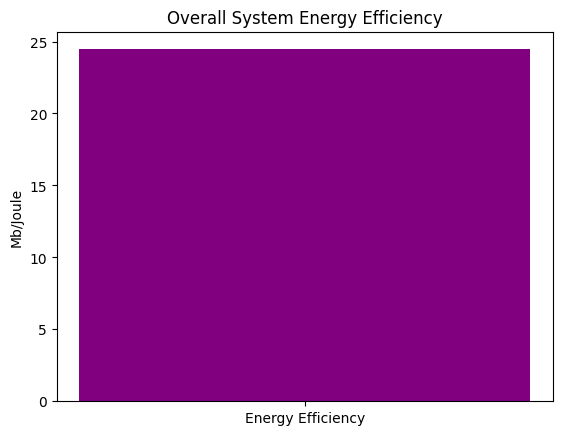

Optimal Coalition Assignments (ED -> SAP): [2 1 2 0 1 4 1 0 0 2 1 0 0 4 4 0 0 1 0 0]
SAP 1: Devices [3, 7, 8, 11, 12, 15, 16, 18, 19]
SAP 2: Devices [1, 4, 6, 10, 17]
SAP 3: Devices [0, 2, 9]
SAP 4: Devices []
SAP 5: Devices [5, 13, 14]
Total Throughput: 141.56 Mb/s
Average Delay: 0.48 seconds
Total Energy Consumption: 5.79 Joules
Energy Efficiency: 24.46 Mb/Joule


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Weight for delay in the reward function
beta = 0.25  # Weight for load penalty
gamma = 0.2  # Weight for energy consumption penalty

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Min-Max load balancing penalty
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Penalty for under-utilization
        return 2 * (3 - load)
    elif load > 10:  # Strong penalty for overloading SAPs
        return 3 * (load - 10)
    elif load > threshold:
        return load - threshold
    else:
        return 0  # No penalty if within the optimal range

# Reward function with energy efficiency consideration
def reward_function(ed, sap):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Calculate load distribution penalty for the SAP
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to the SAP
    load_penalty = min_max_load_penalty(load)

    # Energy consumption model (e.g., proportional to delay, 0.5W per second)
    energy_consumption = delay * 0.5

    # Total reward considering throughput, delay, load balancing, and energy consumption
    reward = throughput - alpha * delay - beta * load_penalty - gamma * energy_consumption
    return reward

# Initialize Q-Table
q_table = np.zeros((num_eds, num_saps))

# Q-Learning algorithm
for episode in range(episodes):
    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        # Calculate reward
        reward = reward_function(ed, action)

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# Determine the optimal coalition assignments
optimal_assignment = np.argmax(q_table, axis=1)

# Calculate load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

# Plotting load distribution across SAPs
plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Calculate throughput and delay per SAP
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) if np.sum(optimal_assignment == sap) > 0 else 0 for sap in range(num_saps)]

# Plot throughput and delay per SAP
fig, ax1 = plt.subplots()

# Throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Calculate total energy consumption
energy_per_sap = [sum(delay_matrix[ed, optimal_assignment[ed]] * 0.5 for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
total_energy_consumption = sum(energy_per_sap)

# Calculate system energy efficiency (Throughput per unit energy)
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
energy_efficiency = total_throughput / total_energy_consumption if total_energy_consumption > 0 else 0

# Visualize energy consumption
plt.bar(range(num_saps), energy_per_sap, color='orange')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Energy Consumption (Joules)')
plt.title('Energy Consumption per SAP')
plt.show()

# Visualize overall energy efficiency
plt.bar(['Energy Efficiency'], [energy_efficiency], color='purple')
plt.ylabel('Mb/Joule')
plt.title('Overall System Energy Efficiency')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {average_delay:.2f} seconds")
print(f"Total Energy Consumption: {total_energy_consumption:.2f} Joules")
print(f"Energy Efficiency: {energy_efficiency:.2f} Mb/Joule")


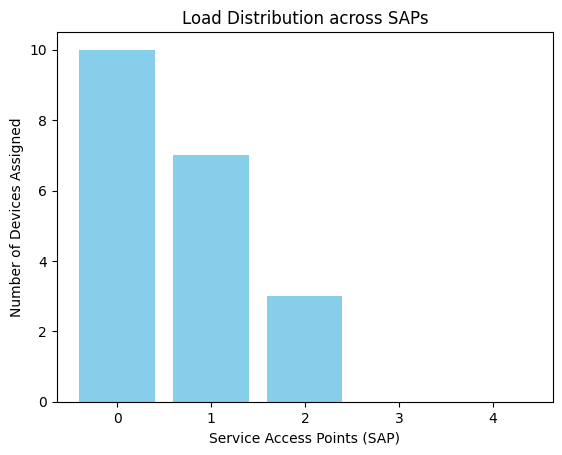

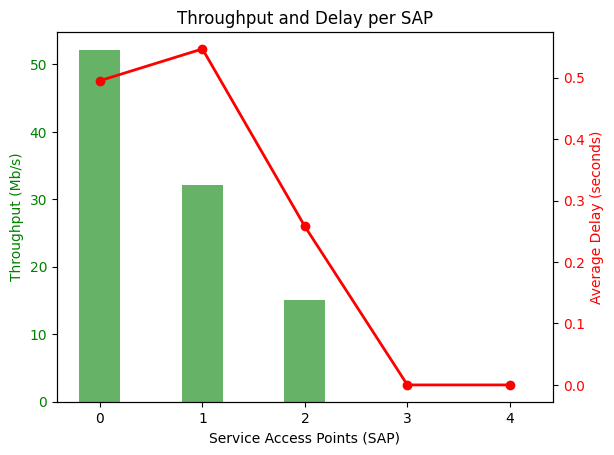

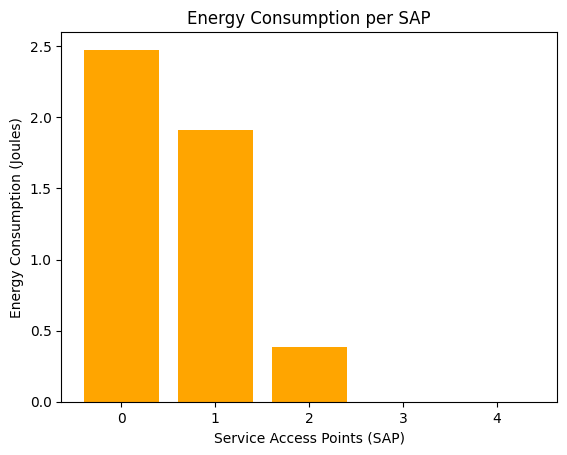

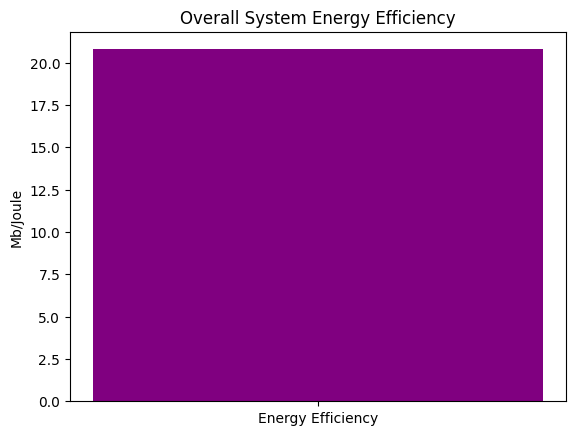

Optimal Coalition Assignments (ED -> SAP): [2 1 1 0 0 2 0 1 0 1 0 0 1 1 0 2 0 1 0 0]
SAP 1: Devices [3, 4, 6, 8, 10, 11, 14, 16, 18, 19]
SAP 2: Devices [1, 2, 7, 9, 12, 13, 17]
SAP 3: Devices [0, 5, 15]
SAP 4: Devices []
SAP 5: Devices []
Total Throughput: 99.31 Mb/s
Average Delay: 0.52 seconds
Total Energy Consumption: 4.78 Joules
Energy Efficiency: 20.79 Mb/Joule


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Weight for delay in the reward function
beta = 0.25  # Weight for load penalty
gamma = 0.2  # Weight for energy consumption penalty

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Simulated dynamic changes in network (Digital Twin approach)
def dynamic_conditions():
    # Randomly simulate changes in delay and throughput (for Digital Twin model)
    throughput_matrix = np.random.rand(num_eds, num_saps) * 10
    delay_matrix = np.random.rand(num_eds, num_saps)
    return throughput_matrix, delay_matrix

# Min-Max load balancing penalty
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Penalty for under-utilization
        return 2 * (3 - load)
    elif load > 10:  # Strong penalty for overloading SAPs
        return 3 * (load - 10)
    elif load > threshold:
        return load - threshold
    else:
        return 0  # No penalty if within the optimal range

# Reward function with cache optimization and energy efficiency
def reward_function(ed, sap, cache_capacity, cache):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Simulate cache hit or miss (this is simplified for illustration)
    data_accessed = random.choice([True, False])  # Randomly simulate data access
    if data_accessed:
        cache_hit = True  # Data was found in cache
        cache_penalty = 0  # No penalty
    else:
        cache_hit = False  # Data was not found in cache
        cache_penalty = 1  # Penalty for cache miss (e.g., increased delay)

    # Cache penalty for miss
    cache_penalty_factor = 0.5 if cache_hit else 2  # Penalize cache misses more heavily

    # Calculate load distribution penalty for the SAP
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to SAP
    load_penalty = min_max_load_penalty(load)

    # Energy consumption model (e.g., proportional to delay, 0.5W per second)
    energy_consumption = delay * 0.5

    # Total reward considering throughput, delay, load balancing, cache, and energy consumption
    reward = throughput - alpha * delay - beta * load_penalty - cache_penalty_factor * cache_penalty - gamma * energy_consumption
    return reward

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Implementing the Q-Learning Algorithm with a leader-follower approach
for episode in range(episodes):
    # Simulate dynamic conditions (Digital Twin)
    throughput_matrix, delay_matrix = dynamic_conditions()

    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        # Reward computation (Leader-follower: SAP as leaders, EDs as followers)
        reward = reward_function(ed, action, 3, [])  # Assume cache size 3 and empty cache for simplicity

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# After training, determine the optimal coalition assignment
optimal_assignment = np.argmax(q_table, axis=1)

# Calculate load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

# Plotting load distribution across SAPs
plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Calculate throughput and delay per SAP
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) if np.sum(optimal_assignment == sap) > 0 else 0 for sap in range(num_saps)]

# Plot throughput and delay per SAP
fig, ax1 = plt.subplots()

# Throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Calculate total energy consumption
energy_per_sap = [sum(delay_matrix[ed, optimal_assignment[ed]] * 0.5 for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
total_energy_consumption = sum(energy_per_sap)

# Calculate system energy efficiency (Throughput per unit energy)
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
energy_efficiency = total_throughput / total_energy_consumption if total_energy_consumption > 0 else 0

# Visualize energy consumption
plt.bar(range(num_saps), energy_per_sap, color='orange')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Energy Consumption (Joules)')
plt.title('Energy Consumption per SAP')
plt.show()

# Visualize overall energy efficiency
plt.bar(['Energy Efficiency'], [energy_efficiency], color='purple')
plt.ylabel('Mb/Joule')
plt.title('Overall System Energy Efficiency')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {np.mean(delay_matrix[ed, optimal_assignment[ed]]):.2f} seconds")
print(f"Total Energy Consumption: {total_energy_consumption:.2f} Joules")
print(f"Energy Efficiency: {energy_efficiency:.2f} Mb/Joule")


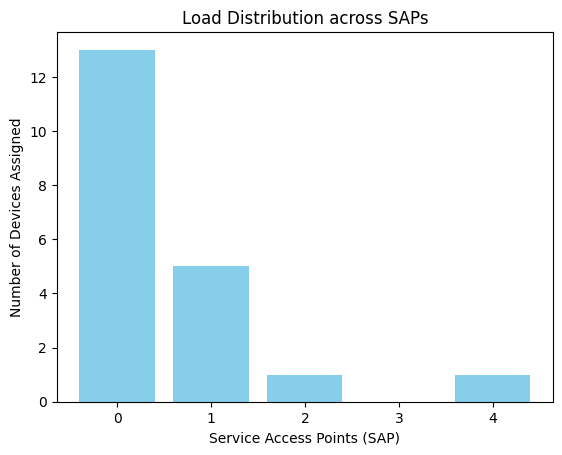

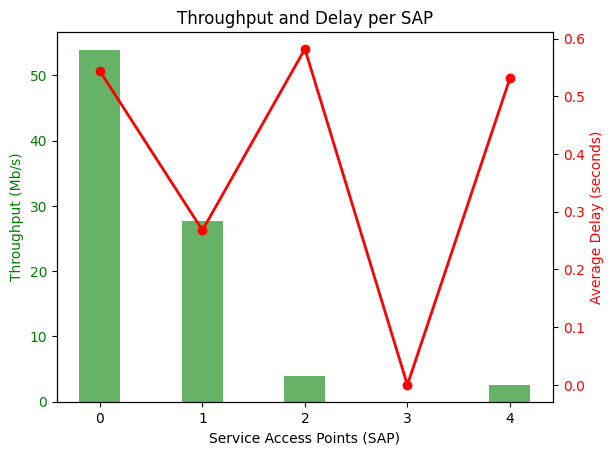

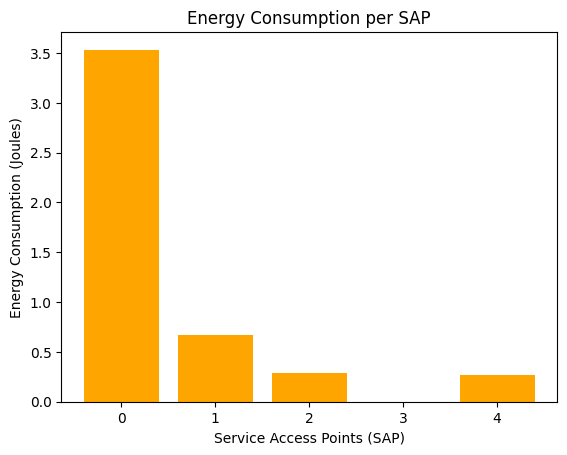

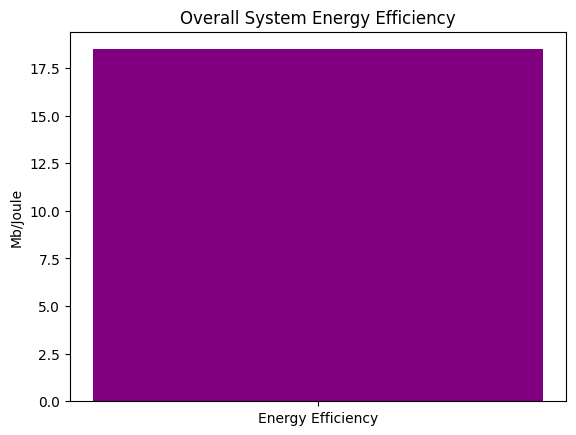

Optimal Coalition Assignments (ED -> SAP): [0 1 1 0 0 0 0 4 0 0 0 0 0 0 0 1 1 2 0 1]
SAP 1: Devices [0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 18]
SAP 2: Devices [1, 2, 15, 16, 19]
SAP 3: Devices [17]
SAP 4: Devices []
SAP 5: Devices [7]
Total Throughput: 88.00 Mb/s
Average Delay: 0.06 seconds
Total Energy Consumption: 4.76 Joules
Energy Efficiency: 18.49 Mb/Joule


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_eds = 20  # Number of edge devices
num_saps = 5  # Number of service access points
episodes = 1000  # Number of episodes for training
learning_rate = 0.1  # Learning rate for Q-Learning
discount_factor = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Weight for delay in the reward function
beta = 0.25  # Weight for load penalty
gamma = 0.2  # Weight for energy consumption penalty

# Environment setup (simulated throughput and delay values)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Simulated dynamic changes in network (Digital Twin approach)
def dynamic_conditions():
    # Randomly simulate changes in delay and throughput (for Digital Twin model)
    throughput_matrix = np.random.rand(num_eds, num_saps) * 10
    delay_matrix = np.random.rand(num_eds, num_saps)
    return throughput_matrix, delay_matrix

# Min-Max load balancing penalty
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Penalty for under-utilization
        return 2 * (3 - load)
    elif load > 10:  # Strong penalty for overloading SAPs
        return 3 * (load - 10)
    elif load > threshold:
        return load - threshold
    else:
        return 0  # No penalty if within the optimal range

# Reward function with cache optimization and energy efficiency
def reward_function(ed, sap, cache_capacity, cache):
    # Throughput and delay for the ED-SAP pair
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]

    # Simulate cache hit or miss (this is simplified for illustration)
    data_accessed = random.choice([True, False])  # Randomly simulate data access
    if data_accessed:
        cache_hit = True  # Data was found in cache
        cache_penalty = 0  # No penalty
    else:
        cache_hit = False  # Data was not found in cache
        cache_penalty = 1  # Penalty for cache miss (e.g., increased delay)

    # Cache penalty for miss
    cache_penalty_factor = 0.5 if cache_hit else 2  # Penalize cache misses more heavily

    # Calculate load distribution penalty for the SAP
    load = np.sum(optimal_assignment == sap)  # Number of devices assigned to SAP
    load_penalty = min_max_load_penalty(load)

    # Energy consumption model (e.g., proportional to delay, 0.5W per second)
    energy_consumption = delay * 0.5

    # Total reward considering throughput, delay, load balancing, cache, and energy consumption
    reward = throughput - alpha * delay - beta * load_penalty - cache_penalty_factor * cache_penalty - gamma * energy_consumption
    return reward

# Q-Table initialization
q_table = np.zeros((num_eds, num_saps))

# Implementing the Q-Learning Algorithm with a leader-follower approach
for episode in range(episodes):
    # Simulate dynamic conditions (Digital Twin)
    throughput_matrix, delay_matrix = dynamic_conditions()

    for ed in range(num_eds):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: choose random SAP
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        # Reward computation (Leader-follower: SAP as leaders, EDs as followers)
        reward = reward_function(ed, action, 3, [])  # Assume cache size 3 and empty cache for simplicity

        # Update Q-Table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    # Decay epsilon to reduce exploration over time
    epsilon = max(0.01, epsilon * 0.99)

# After training, determine the optimal coalition assignment
optimal_assignment = np.argmax(q_table, axis=1)

# Calculate load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

# Plotting load distribution across SAPs
plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Calculate throughput and delay per SAP
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) if np.sum(optimal_assignment == sap) > 0 else 0 for sap in range(num_saps)]

# Plot throughput and delay per SAP
fig, ax1 = plt.subplots()

# Throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Calculate total energy consumption
energy_per_sap = [sum(delay_matrix[ed, optimal_assignment[ed]] * 0.5 for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
total_energy_consumption = sum(energy_per_sap)

# Calculate system energy efficiency (Throughput per unit energy)
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
energy_efficiency = total_throughput / total_energy_consumption if total_energy_consumption > 0 else 0

# Visualize energy consumption
plt.bar(range(num_saps), energy_per_sap, color='orange')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Energy Consumption (Joules)')
plt.title('Energy Consumption per SAP')
plt.show()

# Visualize overall energy efficiency
plt.bar(['Energy Efficiency'], [energy_efficiency], color='purple')
plt.ylabel('Mb/Joule')
plt.title('Overall System Energy Efficiency')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {np.mean(delay_matrix[ed, optimal_assignment[ed]]):.2f} seconds")
print(f"Total Energy Consumption: {total_energy_consumption:.2f} Joules")
print(f"Energy Efficiency: {energy_efficiency:.2f} Mb/Joule")


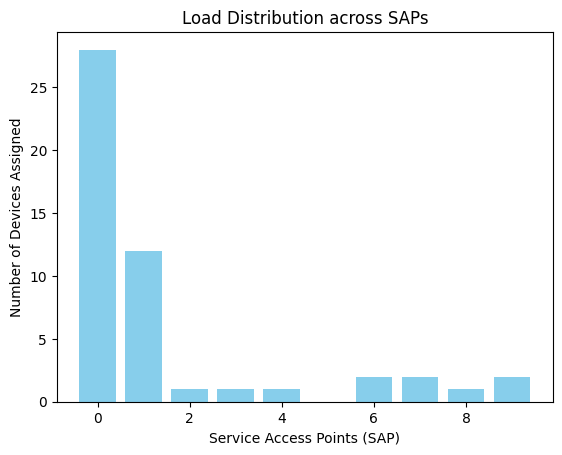

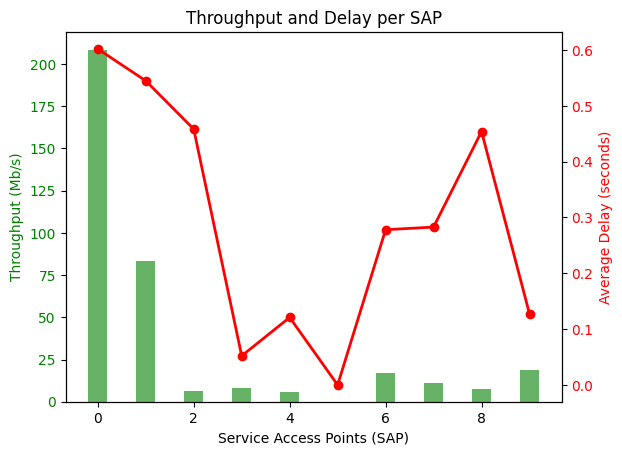

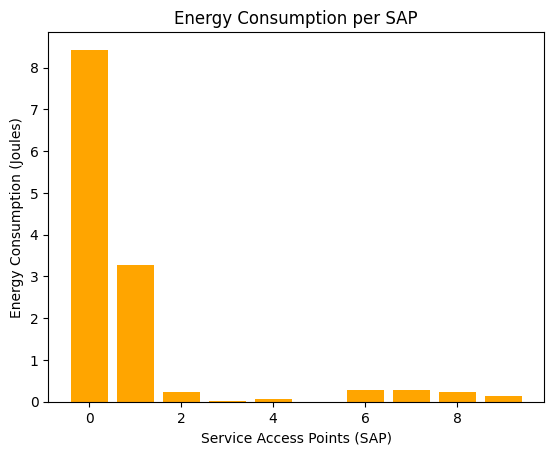

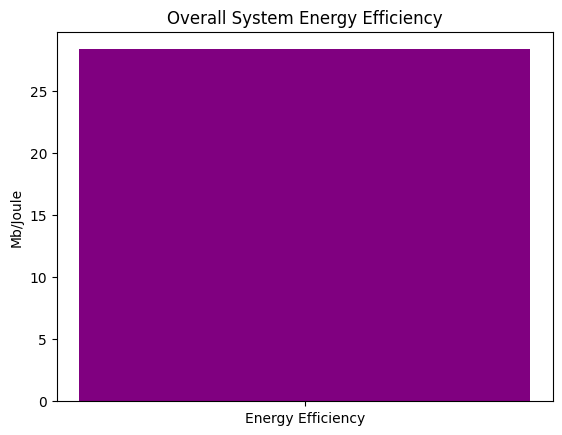

Optimal Coalition Assignments (ED -> SAP): [6 0 2 1 1 1 1 0 0 3 1 0 1 9 8 0 0 9 1 0 1 0 0 1 1 0 0 0 0 7 0 0 0 0 0 0 6
 1 0 0 0 7 0 0 4 0 0 0 0 1]
SAP 1: Devices [1, 7, 8, 11, 15, 16, 19, 21, 22, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 38, 39, 40, 42, 43, 45, 46, 47, 48]
SAP 2: Devices [3, 4, 5, 6, 10, 12, 18, 20, 23, 24, 37, 49]
SAP 3: Devices [2]
SAP 4: Devices [9]
SAP 5: Devices [44]
SAP 6: Devices []
SAP 7: Devices [0, 36]
SAP 8: Devices [29, 41]
SAP 9: Devices [14]
SAP 10: Devices [13, 17]
Total Throughput: 366.90 Mb/s
Average Delay: 0.16 seconds
Total Energy Consumption: 12.93 Joules
Energy Efficiency: 28.38 Mb/Joule


In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Parameters for a larger system
num_eds = 50  # Increase the number of edge devices
num_saps = 10  # Increase the number of service access points
episodes = 1000  # Number of episodes for Q-learning training
learning_rate = 0.1  # Learning rate
discount_factor = 0.9  # Discount factor
epsilon = 0.1  # Epsilon-greedy exploration probability

# Define alpha and beta for controlling the weight of delay and load penalty
alpha = 0.5  # Weight for delay in the reward function
beta = 0.25  # Weight for load penalty
gamma = 0.2  # Weight for energy consumption penalty

# Reinitialize environment for larger system (throughput and delay)
throughput_matrix = np.random.rand(num_eds, num_saps) * 10  # Throughput values (Mb/s)
delay_matrix = np.random.rand(num_eds, num_saps)  # Delay values (seconds)

# Initialize Q-table
q_table = np.zeros((num_eds, num_saps))

# Min-Max load balancing penalty function
def min_max_load_penalty(load, threshold=4):
    if load < 3:  # Penalty for under-utilization
        return 2 * (3 - load)
    elif load > 10:  # Strong penalty for overloading SAPs
        return 3 * (load - 10)
    elif load > threshold:
        return load - threshold
    else:
        return 0  # No penalty if within the optimal range

# Reward function considering throughput, delay, load, and energy consumption
def reward_function(ed, sap, cache_capacity, cache):
    throughput = throughput_matrix[ed, sap]
    delay = delay_matrix[ed, sap]
    load = np.sum(optimal_assignment == sap)
    load_penalty = min_max_load_penalty(load)
    energy_consumption = delay * 0.5  # Energy consumption as a function of delay

    reward = throughput - alpha * delay - beta * load_penalty - gamma * energy_consumption
    return reward

# Simulated Annealing Cache Optimization
def simulated_annealing(cache_capacity, access_data, temperature=1000, cooling_rate=0.95, iterations=100):
    current_cache = random.sample(access_data, cache_capacity)
    current_cost = calculate_cache_cost(current_cache, access_data)

    for i in range(iterations):
        temperature *= cooling_rate
        new_cache = current_cache[:]
        swap_idx1, swap_idx2 = random.sample(range(len(new_cache)), 2)
        new_cache[swap_idx1], new_cache[swap_idx2] = new_cache[swap_idx2], new_cache[swap_idx1]
        new_cost = calculate_cache_cost(new_cache, access_data)

        if new_cost < current_cost or random.uniform(0, 1) < math.exp((current_cost - new_cost) / temperature):
            current_cache = new_cache
            current_cost = new_cost

    return current_cache

# Calculate cache cost based on cache hits and misses
def calculate_cache_cost(cache, access_data):
    cache_hits = sum(1 for item in cache if item in access_data)
    cache_misses = len(access_data) - cache_hits
    return cache_misses  # Minimize the cache misses

# Q-learning algorithm for larger system
for episode in range(episodes):
    for ed in range(num_eds):
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_saps - 1)  # Explore: random SAP choice
        else:
            action = np.argmax(q_table[ed])  # Exploit: choose best-known SAP

        reward = reward_function(ed, action, 3, [])  # Assume cache size of 3 for simplicity

        # Update Q-table using Bellman equation
        next_max = np.max(q_table[ed])  # Max Q-value for the next state
        q_table[ed, action] += learning_rate * (reward + discount_factor * next_max - q_table[ed, action])

    epsilon = max(0.01, epsilon * 0.99)

# After training, determine the optimal coalition assignment
optimal_assignment = np.argmax(q_table, axis=1)

# Calculate load distribution across SAPs
load_distribution = [np.sum(optimal_assignment == i) for i in range(num_saps)]

# Plotting load distribution across SAPs
plt.bar(range(num_saps), load_distribution, color='skyblue')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Number of Devices Assigned')
plt.title('Load Distribution across SAPs')
plt.show()

# Calculate throughput and delay per SAP
throughput_per_sap = [sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
delay_per_sap = [np.mean([delay_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds) if optimal_assignment[ed] == sap]) if np.sum(optimal_assignment == sap) > 0 else 0 for sap in range(num_saps)]

# Plot throughput and delay per SAP
fig, ax1 = plt.subplots()

# Throughput
ax1.bar(range(num_saps), throughput_per_sap, color='green', alpha=0.6, label='Throughput (Mb/s)', width=0.4, align='center')
ax1.set_xlabel('Service Access Points (SAP)')
ax1.set_ylabel('Throughput (Mb/s)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Delay
ax2 = ax1.twinx()
ax2.plot(range(num_saps), delay_per_sap, color='red', marker='o', label='Average Delay (seconds)', linewidth=2)
ax2.set_ylabel('Average Delay (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Throughput and Delay per SAP')
plt.show()

# Calculate total energy consumption
energy_per_sap = [sum(delay_matrix[ed, optimal_assignment[ed]] * 0.5 for ed in range(num_eds) if optimal_assignment[ed] == sap) for sap in range(num_saps)]
total_energy_consumption = sum(energy_per_sap)

# Calculate system energy efficiency (Throughput per unit energy)
total_throughput = sum(throughput_matrix[ed, optimal_assignment[ed]] for ed in range(num_eds))
energy_efficiency = total_throughput / total_energy_consumption if total_energy_consumption > 0 else 0

# Visualize energy consumption
plt.bar(range(num_saps), energy_per_sap, color='orange')
plt.xlabel('Service Access Points (SAP)')
plt.ylabel('Energy Consumption (Joules)')
plt.title('Energy Consumption per SAP')
plt.show()

# Visualize overall energy efficiency
plt.bar(['Energy Efficiency'], [energy_efficiency], color='purple')
plt.ylabel('Mb/Joule')
plt.title('Overall System Energy Efficiency')
plt.show()

# Print results
print("Optimal Coalition Assignments (ED -> SAP):", optimal_assignment)
for sap in range(num_saps):
    assigned_eds = np.where(optimal_assignment == sap)[0]
    print(f"SAP {sap + 1}: Devices {assigned_eds.tolist()}")

print(f"Total Throughput: {total_throughput:.2f} Mb/s")
print(f"Average Delay: {np.mean(delay_matrix[ed, optimal_assignment[ed]]):.2f} seconds")
print(f"Total Energy Consumption: {total_energy_consumption:.2f} Joules")
print(f"Energy Efficiency: {energy_efficiency:.2f} Mb/Joule")
